In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import HistGradientBoostingRegressor


In [2]:
train_df = pd.read_csv("train_df.csv", sep=",")
test_df  = pd.read_csv("test_df.csv",  sep=",")


In [3]:
sort_cols = ["date", "logistieke location id", "crop_type", "fpc_index", "horizon"]

train_df = train_df.sort_values(sort_cols).reset_index(drop=True)
test_df  = test_df.sort_values(sort_cols).reset_index(drop=True)


In [4]:
cat_cols_to_align = [
    "curr_month", "curr_weekday", "curr_weekofyear",
    "target_month", "target_weekday", "target_weekofyear"
]

for col in cat_cols_to_align:
    if col in train_df.columns and col in test_df.columns:
        train_df[col] = train_df[col].astype("category")
        test_df[col]  = test_df[col].astype("category")
        test_df[col]  = test_df[col].cat.set_categories(train_df[col].cat.categories)


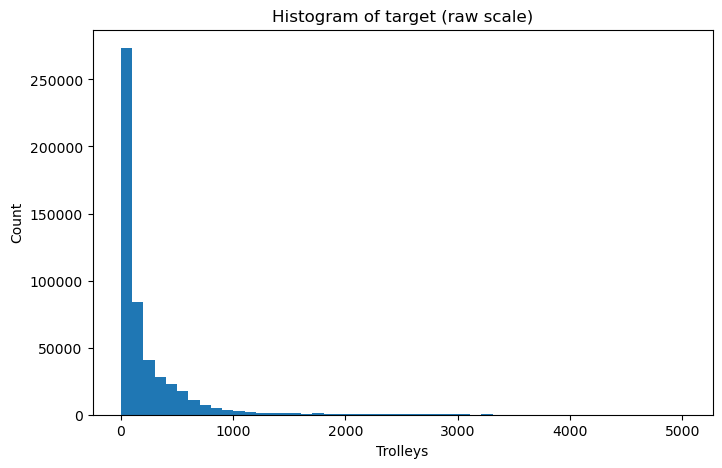

In [5]:
target = "trolleys_target"

plt.figure(figsize=(8, 5))
plt.hist(train_df[target], bins=50)
plt.xlabel("Trolleys")
plt.ylabel("Count")
plt.title("Histogram of target (raw scale)")
plt.show()


In [6]:
X_train = train_df.drop(columns=[target])
y_train = np.log1p(train_df[target].values)

X_test  = test_df.drop(columns=[target])
y_test_raw = test_df[target].values


In [8]:
# Drop columns that should never be features
drop_cols = []
for c in ["date", "target_date"]:
    if c in X_train.columns:
        drop_cols.append(c)

X_train_features = X_train.drop(columns=drop_cols)
X_test_features  = X_test.drop(columns=drop_cols)

numeric_cols = X_train_features.select_dtypes(include=[np.number]).columns
categorical_cols = X_train_features.select_dtypes(exclude=[np.number]).columns

numeric_pipeline = Pipeline([
    ("zv", VarianceThreshold()),
    ("normalize", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("dummy", OneHotEncoder(
        drop="first",
        sparse_output=False,
        handle_unknown="infrequent_if_exist",
        min_frequency=1
    ))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])


In [9]:
def rolling_panel_cv(df, time_col, n_folds, train_blocks):
    times = np.sort(df[time_col].unique())
    blocks = np.array_split(times, n_folds + train_blocks)

    for i in range(n_folds):
        train_times = np.concatenate(blocks[i : i + train_blocks])
        test_times  = blocks[i + train_blocks]

        train_mask = df[time_col].isin(train_times)
        test_mask  = df[time_col].isin(test_times)

        train_idx = np.flatnonzero(train_mask.values)
        test_idx  = np.flatnonzero(test_mask.values)

        yield train_idx, test_idx


In [16]:
# 3) Model (time-series safe: no random validation split inside folds)
gbr = HistGradientBoostingRegressor(
    loss="squared_error",
    random_state=42,
    early_stopping=False
)

pipe = Pipeline([
    ("preprocess", tree_preprocess),
    ("gbr", gbr),
])

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=8,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=42,
    error_score="raise"
)

search.fit(X_train_features, y_train)

# final fitted model (refit with chosen 1SE params)
results = pd.DataFrame(search.cv_results_)
results["mean_mse"] = -results["mean_test_score"]
results["se_mse"] = results["std_test_score"] / np.sqrt(len(cv))

best_idx = results["mean_mse"].idxmin()
best_row = results.loc[best_idx]
threshold = best_row["mean_mse"] + best_row["se_mse"]

within_1se = results[results["mean_mse"] <= threshold].copy()

def tree_complexity_key(row):
    msl = int(row["param_gbr__min_samples_leaf"])
    l2  = float(row["param_gbr__l2_regularization"])
    lr  = float(row["param_gbr__learning_rate"])
    mln = int(row["param_gbr__max_leaf_nodes"])
    it  = int(row["param_gbr__max_iter"])
    md  = row["param_gbr__max_depth"]
    md_val = 999 if (pd.isna(md) or md is None) else int(md)
    return (-msl, -l2, md_val, mln, lr, it)

within_1se["ckey"] = within_1se.apply(tree_complexity_key, axis=1)
chosen_1se = within_1se.sort_values("ckey", ascending=True).iloc[0]

print("Best params:", search.best_params_)
print("Best CV MSE (log-scale):", best_row["mean_mse"])
print("1SE threshold (log-scale):", threshold)
print("Chosen 1SE params:", chosen_1se["params"])
print("Chosen 1SE mean MSE:", chosen_1se["mean_mse"])

final_model = search.best_estimator_.set_params(**chosen_1se["params"])
final_model.fit(X_train_features, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'gbr__min_samples_leaf': 50, 'gbr__max_leaf_nodes': 63, 'gbr__max_iter': 200, 'gbr__max_depth': 5, 'gbr__learning_rate': 0.1, 'gbr__l2_regularization': 0.1}
Best CV MSE (log-scale): 0.3040423815749277
1SE threshold (log-scale): 0.3319324398228958
Chosen 1SE params: {'gbr__min_samples_leaf': 100, 'gbr__max_leaf_nodes': 63, 'gbr__max_iter': 200, 'gbr__max_depth': None, 'gbr__learning_rate': 0.03, 'gbr__l2_regularization': 0.1}
Chosen 1SE mean MSE: 0.3136318174597638


,steps,"[('preprocess', ...), ('gbr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
#— Predict on test 
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display

# Otherwise use X_test /// raw feature
X_test_for_pred = X_test_features if "X_test_features" in globals() else X_test

# Predict in log-space
y_pred_log = final_model.predict(X_test_for_pred)

# Back-transform to raw scale (log1p -> raw)
y_pred = np.expm1(y_pred_log)

# True target on raw scale
# If you still have test_df[target] on raw scale, use it
y_true = test_df[target].values if "test_df" in globals() else np.expm1(y_test)

# Buil table for analysis /// keep key columns + preds
key_cols = ["date", "logistieke location id", "crop_type", "fpc_index", "horizon", "is_holiday"]
key_cols = [c for c in key_cols if c in (X_test.columns if "X_test" in globals() else test_df.columns)]

test_with_preds = (X_test[key_cols].copy() if "X_test" in globals() else test_df[key_cols].copy())
test_with_preds["y_true"] = y_true
test_with_preds["y_pred"] = y_pred

print("test_with_preds shape:", test_with_preds.shape)
display(test_with_preds.head(10))


test_with_preds shape: (170647, 8)


,date,logistieke location id,crop_type,fpc_index,horizon,is_holiday,y_true,y_pred
0,2023-10-24,Aalsmeer,BL,fpc_1,50,True,353.0,162.760285
1,2023-10-24,Aalsmeer,BL,fpc_10,50,True,189.0,291.107528
2,2023-10-24,Aalsmeer,BL,fpc_12,50,True,80.0,39.610881
3,2023-10-24,Aalsmeer,BL,fpc_13,50,True,280.0,159.142009
4,2023-10-24,Aalsmeer,BL,fpc_16,50,True,501.0,279.490486
5,2023-10-24,Aalsmeer,BL,fpc_17,50,True,274.0,183.048940
6,2023-10-24,Aalsmeer,BL,fpc_2,50,True,68.0,35.414209
7,2023-10-24,Aalsmeer,BL,fpc_22,50,True,2907.0,1882.068794
8,2023-10-24,Aalsmeer,BL,fpc_23,50,True,1757.0,1351.485193
9,2023-10-24,Aalsmeer,BL,fpc_24,50,True,36.0,29.623615


In [42]:
# C Metrics helpers + Row-level metrics 
def mape_safe(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def mape_nonzero(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.abs(y_true) > eps
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / np.abs(y_true[mask]))) * 100

rmse = np.sqrt(mean_squared_error(test_with_preds["y_true"], test_with_preds["y_pred"]))
mae  = mean_absolute_error(test_with_preds["y_true"], test_with_preds["y_pred"])
mape = mape_safe(test_with_preds["y_true"], test_with_preds["y_pred"])
mape_nz = mape_nonzero(test_with_preds["y_true"], test_with_preds["y_pred"])

print("\nTest performance (row-level, raw scale):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE (safe, includes zeros): {mape:.2f}%")
print(f"MAPE (nonzero y_true only): {mape_nz:.2f}%")



Test performance (row-level, raw scale):
RMSE: 101.7318
MAE : 42.2623
MAPE (safe, includes zeros): 4471748074.19%
MAPE (nonzero y_true only): 36.85%


In [43]:
#  date + location + crop + horizon 

baw_cols = ["date", "logistieke location id", "crop_type", "horizon"]
baw_cols = [c for c in baw_cols if c in test_with_preds.columns]

agg_baw = (
    test_with_preds
    .groupby(baw_cols, as_index=False)[["y_true", "y_pred"]]
    .sum()
)

print("agg_baw shape:", agg_baw.shape)
display(agg_baw.head(10))

rmse_baw = np.sqrt(mean_squared_error(agg_baw["y_true"], agg_baw["y_pred"]))
mae_baw  = mean_absolute_error(agg_baw["y_true"], agg_baw["y_pred"])
mape_baw = mape_safe(agg_baw["y_true"], agg_baw["y_pred"])

print("\nTest performance (BAW level = SUM):")
print(f"RMSE: {rmse_baw:.4f}")
print(f"MAE : {mae_baw:.4f}")
print(f"MAPE: {mape_baw:.2f}%")


agg_baw shape: (12520, 6)


,date,logistieke location id,crop_type,horizon,y_true,y_pred
0,2023-10-24,Aalsmeer,BL,50,8191.0,5695.840902
1,2023-10-24,Aalsmeer,PL,50,2007.0,1826.145235
2,2023-10-24,Naaldwijk,BL,50,2549.0,2001.097035
3,2023-10-24,Naaldwijk,PL,50,1403.0,1322.485890
4,2023-10-24,Rijnsburg,BL,50,1624.0,1270.323064
5,2023-10-31,Aalsmeer,BL,45,8191.0,5728.959742
6,2023-10-31,Aalsmeer,BL,46,5710.0,5570.932836
7,2023-10-31,Aalsmeer,BL,47,4292.0,4375.653137
8,2023-10-31,Aalsmeer,BL,48,6737.0,6149.582804
9,2023-10-31,Aalsmeer,BL,49,7784.0,7400.318093



Test performance (BAW level = SUM):
RMSE: 569.9071
MAE : 321.4031
MAPE: 10.07%


In [44]:

# Crop-type report + split: holidays / no_holidays / all_dates
have_holiday = "is_holiday" in test_with_preds.columns

def crop_report(df):
    gcols = ["crop_type", "horizon"]
    rep = df.groupby(gcols, as_index=False)[["y_true", "y_pred"]].sum()
    rep["MAPE_%"] = [mape_safe(yt, yp) for yt, yp in zip(rep["y_true"], rep["y_pred"])]
    rep = rep.sort_values("MAPE_%", ascending=False)
    return rep

# all dates
crop_all = crop_report(agg_baw)

if have_holiday:
    agg_baw_h = agg_baw.merge(
        test_with_preds[baw_cols + ["is_holiday"]].drop_duplicates(),
        on=baw_cols,
        how="left"
    )
    crop_holidays = crop_report(agg_baw_h[agg_baw_h["is_holiday"] == 1])
    crop_nohol    = crop_report(agg_baw_h[agg_baw_h["is_holiday"] == 0])

print("\nCROP report — ALL DATES (top 30 worst MAPE):")
display(crop_all.head(30))

if have_holiday:
    print("\nCROP report — HOLIDAYS ONLY (top 30 worst MAPE):")
    display(crop_holidays.head(30))
    print("\nCROP report — NO HOLIDAYS (top 30 worst MAPE):")
    display(crop_nohol.head(30))



CROP report — ALL DATES (top 30 worst MAPE):


,crop_type,horizon,y_true,y_pred,MAPE_%
38,BL,39,729613.0,644093.159837,11.721260
43,BL,44,728193.0,644224.701020,11.531050
48,BL,49,726799.0,643781.793856,11.422306
33,BL,34,727692.0,648158.674384,10.929531
28,BL,29,728579.0,650855.795872,10.667780
37,BL,38,634666.0,568845.219942,10.370932
42,BL,43,633044.0,567695.763829,10.322858
47,BL,48,631393.0,566390.650004,10.295070
18,BL,19,732964.0,658336.722877,10.181575
23,BL,24,731333.0,657257.772580,10.128796



CROP report — HOLIDAYS ONLY (top 30 worst MAPE):


,crop_type,horizon,y_true,y_pred,MAPE_%
24,BL,25,123892.0,95779.353944,22.691252
23,BL,24,98227.0,76128.228513,22.497655
44,BL,45,121890.0,94946.696826,22.104605
43,BL,44,95810.0,74887.937378,21.837034
38,BL,39,112063.0,87745.239028,21.700080
34,BL,35,122613.0,96180.970328,21.557282
49,BL,50,121550.0,95989.188389,21.029051
29,BL,30,121057.0,95685.464477,20.958338
28,BL,29,95602.0,75770.657175,20.743648
39,BL,40,134177.0,106799.788950,20.403803



CROP report — NO HOLIDAYS (top 30 worst MAPE):


,crop_type,horizon,y_true,y_pred,MAPE_%
48,BL,49,631991.0,566431.124488,10.373546
43,BL,44,632383.0,569336.763642,9.969629
38,BL,39,617550.0,556347.920809,9.910465
33,BL,34,632825.0,571371.176508,9.711030
3,BL,4,633237.0,575265.369990,9.154808
28,BL,29,632977.0,575085.138697,9.145966
8,BL,9,621256.0,566391.554034,8.831214
18,BL,19,620902.0,567865.733456,8.541810
13,BL,14,621111.0,568085.480171,8.537205
23,BL,24,633106.0,581129.544067,8.209756


In [45]:
#Crop+FPC report 
if "fpc_index" in test_with_preds.columns:
    gcols = ["crop_type", "fpc_index", "horizon"]
    agg_crop_fpc = (
        test_with_preds
        .groupby(gcols + (["is_holiday"] if have_holiday else []), as_index=False)[["y_true", "y_pred"]]
        .sum()
    )

    
    def regime_summary(df, level_name=""):
        out = {}
        out["MAE"]  = mean_absolute_error(df["y_true"], df["y_pred"])
        out["RMSE"] = np.sqrt(mean_squared_error(df["y_true"], df["y_pred"]))
        out["MAPE_%"] = mape_safe(df["y_true"], df["y_pred"])
        out["n_rows"] = len(df)
        return pd.Series(out, name=level_name)

    if have_holiday:
        #  at crop+fpc level
        all_dates = agg_crop_fpc.copy()
        hol_only  = agg_crop_fpc[agg_crop_fpc["is_holiday"] == 1]
        no_hol    = agg_crop_fpc[agg_crop_fpc["is_holiday"] == 0]

        summary = pd.DataFrame([
            regime_summary(no_hol,   "no_holidays"),
            regime_summary(all_dates,"all_dates"),
            regime_summary(hol_only, "holidays_only"),
        ])
        display(summary)

    def crop_fpc_table(df):
        tmp = df.groupby(gcols, as_index=False)[["y_true", "y_pred"]].sum()
        tmp["MAPE_%"] = [mape_safe(yt, yp) for yt, yp in zip(tmp["y_true"], tmp["y_pred"])]
        return tmp.sort_values("MAPE_%", ascending=False)

    print("\nCROP+FPC report — ALL DATES (top 50 worst MAPE):")
    display(crop_fpc_table(test_with_preds).head(50))

    if have_holiday:
        print("\nCROP+FPC report — HOLIDAYS ONLY (top 50 worst MAPE):")
        display(crop_fpc_table(test_with_preds[test_with_preds["is_holiday"] == 1]).head(50))
        print("\nCROP+FPC report — NO HOLIDAYS (top 50 worst MAPE):")
        display(crop_fpc_table(test_with_preds[test_with_preds["is_holiday"] == 0]).head(50))
else:
    print("No fpc_index column found -> skipping Crop+FPC report.")


,MAE,RMSE,MAPE_%,n_rows
no_holidays,1493.552139,3217.755462,13.511052,1499.0
all_dates,1158.617135,2690.347210,16.824141,2934.0
holidays_only,808.744264,1995.749328,20.284991,1435.0



CROP+FPC report — ALL DATES (top 50 worst MAPE):


,crop_type,fpc_index,horizon,y_true,y_pred,MAPE_%
123,BL,fpc_11,24,3.0,12.626888,320.896277
124,BL,fpc_11,25,2.0,8.409484,320.474223
125,BL,fpc_11,26,2.0,7.822497,291.124875
121,BL,fpc_11,22,1.0,3.783402,278.340223
142,BL,fpc_11,43,3.0,10.600922,253.364055
118,BL,fpc_11,19,4.0,13.753007,243.825163
120,BL,fpc_11,21,3.0,9.678273,222.609089
119,BL,fpc_11,20,3.0,9.436087,214.536218
128,BL,fpc_11,29,3.0,9.316160,210.538674
129,BL,fpc_11,30,2.0,6.022820,201.141000



CROP+FPC report — HOLIDAYS ONLY (top 50 worst MAPE):


,crop_type,fpc_index,horizon,y_true,y_pred,MAPE_%
118,BL,fpc_11,24,1.0,7.225576,622.557613
119,BL,fpc_11,25,1.0,6.116592,511.659176
828,PL,fpc_10,3,4.0,24.416141,510.403515
826,PL,fpc_10,1,5.0,22.879207,357.584133
106,BL,fpc_11,9,1.0,4.373748,337.374825
123,BL,fpc_11,33,2.0,8.014801,300.740072
120,BL,fpc_11,26,2.0,7.822497,291.124875
124,BL,fpc_11,36,1.0,3.597581,259.758140
125,BL,fpc_11,38,1.0,3.580572,258.057213
107,BL,fpc_11,10,1.0,3.553366,255.336567



CROP+FPC report — NO HOLIDAYS (top 50 worst MAPE):


,crop_type,fpc_index,horizon,y_true,y_pred,MAPE_%
120,BL,fpc_11,21,1.0,4.646839,364.683862
121,BL,fpc_11,22,1.0,3.783402,278.340223
141,BL,fpc_11,43,3.0,10.600922,253.364055
115,BL,fpc_11,16,2.0,6.868263,243.413127
118,BL,fpc_11,19,3.0,10.230655,241.021849
119,BL,fpc_11,20,2.0,6.504011,225.200559
127,BL,fpc_11,29,3.0,9.316160,210.538674
128,BL,fpc_11,30,2.0,6.022820,201.141000
137,BL,fpc_11,39,3.0,8.839294,194.643138
146,BL,fpc_11,48,2.0,5.806884,190.344211


,date,logistieke location id,crop_type,fpc_index,horizon,is_holiday,y_true,y_pred
0,2023-10-24,Aalsmeer,BL,fpc_1,50,True,353.0,162.760285
1,2023-10-24,Aalsmeer,BL,fpc_10,50,True,189.0,291.107528
2,2023-10-24,Aalsmeer,BL,fpc_12,50,True,80.0,39.610881
3,2023-10-24,Aalsmeer,BL,fpc_13,50,True,280.0,159.142009
4,2023-10-24,Aalsmeer,BL,fpc_16,50,True,501.0,279.490486
5,2023-10-24,Aalsmeer,BL,fpc_17,50,True,274.0,183.048940
6,2023-10-24,Aalsmeer,BL,fpc_2,50,True,68.0,35.414209
7,2023-10-24,Aalsmeer,BL,fpc_22,50,True,2907.0,1882.068794
8,2023-10-24,Aalsmeer,BL,fpc_23,50,True,1757.0,1351.485193
9,2023-10-24,Aalsmeer,BL,fpc_24,50,True,36.0,29.623615


test_with_preds shape: (170647, 8)


,label,mae,rmse,mape_%,n_rows
0,row,42.262318,101.731806,4.471748e+09,170647


,label,mae,rmse,mape_%,n_rows,n_days
0,baw all,42.262318,101.731806,4.471748e+09,170647,61.0
1,crop day all,321.403078,569.907094,1.006770e+01,12520,61.0
2,crop h all,24186.730085,33797.499865,5.339627e+00,100,NaN
3,crop fpc h all,2048.992236,4504.446593,1.376551e+01,1500,NaN


,label,mae,rmse,mape_%,n_rows,n_days
0,baw no_holidays,38.772132,81.243983,4.940471e+09,140404,60
1,baw holidays_only,58.465608,166.592795,2.295686e+09,30243,48
2,crop day no_holidays,265.884729,416.473183,8.881288e+00,10345,60
3,crop day holidays_only,585.466215,1022.074235,1.571066e+01,2175,48
4,crop h no_holidays,15278.874546,22606.683410,4.429279e+00,100,60
5,crop h holidays_only,10302.576227,14273.304803,1.151961e+01,100,48
6,crop fpc h no_holidays,1493.552139,3217.755462,1.351105e+01,1499,60
7,crop fpc h holidays_only,808.744264,1995.749328,2.028499e+01,1435,48


,regime,mae,rmse,mape_%,n_rows,n_days
0,no_holidays,15278.874546,22606.683410,4.429279,100,60
1,holidays_only,10302.576227,14273.304803,11.519613,100,48
2,all_dates,24186.730085,33797.499865,5.339627,100,61


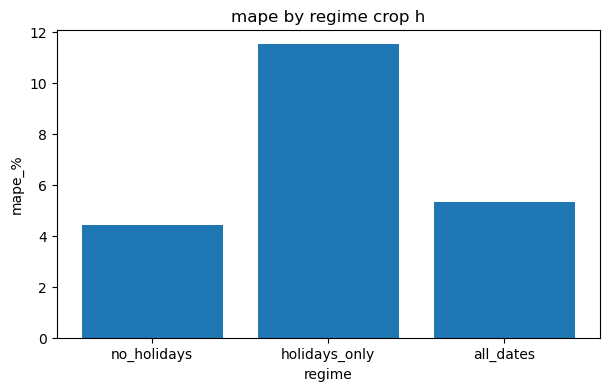

,crop_type,fpc_index,horizon,y_true,y_pred,mape_%
123,BL,fpc_11,24,3.0,12.626888,320.896277
124,BL,fpc_11,25,2.0,8.409484,320.474223
125,BL,fpc_11,26,2.0,7.822497,291.124875
121,BL,fpc_11,22,1.0,3.783402,278.340223
142,BL,fpc_11,43,3.0,10.600922,253.364055
118,BL,fpc_11,19,4.0,13.753007,243.825163
120,BL,fpc_11,21,3.0,9.678273,222.609089
119,BL,fpc_11,20,3.0,9.436087,214.536218
128,BL,fpc_11,29,3.0,9.316160,210.538674
129,BL,fpc_11,30,2.0,6.022820,201.141000


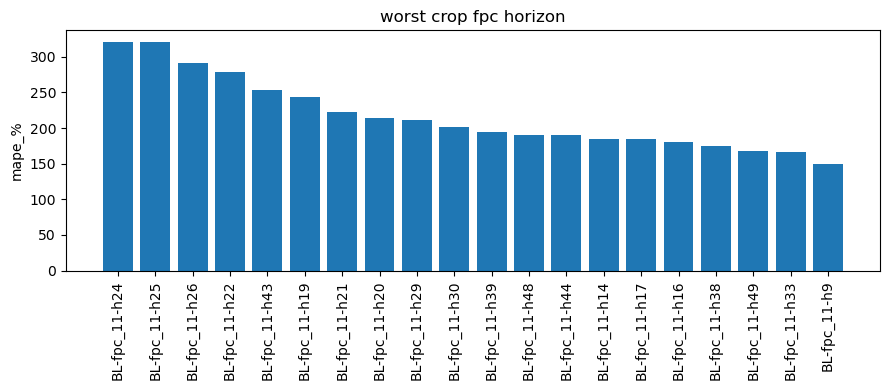

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mape_safe(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), eps)) * 100

def metrics_df(y_true, y_pred, label="", n_rows=None, n_days=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mape_safe(y_true, y_pred)
    out = {"label": label, "mae": mae, "rmse": rmse, "mape_%": mape}
    if n_rows is not None:
        out["n_rows"] = n_rows
    if n_days is not None:
        out["n_days"] = n_days
    return pd.DataFrame([out])

def agg_sum_and_metrics(df, group_cols, label):
    gcols = [c for c in group_cols if c in df.columns]
    agg = df.groupby(gcols, as_index=False)[["y_true", "y_pred"]].sum()
    n_rows = len(agg)
    n_days = agg["date"].nunique() if "date" in agg.columns else None
    return agg, metrics_df(agg["y_true"], agg["y_pred"], label=label, n_rows=n_rows, n_days=n_days)

y_pred_log = final_model.predict(X_test_features)
y_pred = np.expm1(y_pred_log)

y_true = test_df[target].values.astype(float)

key_cols = ["date", "logistieke location id", "crop_type", "fpc_index", "horizon", "is_holiday"]
key_cols = [c for c in key_cols if c in test_df.columns]

test_with_preds = test_df[key_cols].copy()
test_with_preds["y_true"] = y_true
test_with_preds["y_pred"] = y_pred

display(test_with_preds.head(10))
print("test_with_preds shape:", test_with_preds.shape)

row_report = metrics_df(test_with_preds["y_true"], test_with_preds["y_pred"], label="row", n_rows=len(test_with_preds))
display(row_report)

baw_cols = ["date", "logistieke location id", "crop_type", "fpc_index", "horizon"]
crop_day_cols = ["date", "logistieke location id", "crop_type", "horizon"]
crop_h_cols = ["crop_type", "horizon"]
crop_fpc_h_cols = ["crop_type", "fpc_index", "horizon"]

agg_baw, baw_all = agg_sum_and_metrics(test_with_preds, baw_cols, label="baw all")
agg_crop_day, crop_day_all = agg_sum_and_metrics(test_with_preds, crop_day_cols, label="crop day all")

agg_crop_h = test_with_preds.groupby([c for c in crop_h_cols if c in test_with_preds.columns], as_index=False)[["y_true","y_pred"]].sum()
crop_h_all = metrics_df(agg_crop_h["y_true"], agg_crop_h["y_pred"], label="crop h all", n_rows=len(agg_crop_h))

agg_crop_fpc_h = test_with_preds.groupby([c for c in crop_fpc_h_cols if c in test_with_preds.columns], as_index=False)[["y_true","y_pred"]].sum()
crop_fpc_h_all = metrics_df(agg_crop_fpc_h["y_true"], agg_crop_fpc_h["y_pred"], label="crop fpc h all", n_rows=len(agg_crop_fpc_h))

display(pd.concat([baw_all, crop_day_all, crop_h_all, crop_fpc_h_all], ignore_index=True))

if "is_holiday" in test_with_preds.columns:
    hol0 = test_with_preds[test_with_preds["is_holiday"] == 0]
    hol1 = test_with_preds[test_with_preds["is_holiday"] == 1]

    _, baw_0 = agg_sum_and_metrics(hol0, baw_cols, label="baw no_holidays")
    _, baw_1 = agg_sum_and_metrics(hol1, baw_cols, label="baw holidays_only")

    _, crop_day_0 = agg_sum_and_metrics(hol0, crop_day_cols, label="crop day no_holidays")
    _, crop_day_1 = agg_sum_and_metrics(hol1, crop_day_cols, label="crop day holidays_only")

    agg_crop_h_0 = hol0.groupby([c for c in crop_h_cols if c in hol0.columns], as_index=False)[["y_true","y_pred"]].sum()
    agg_crop_h_1 = hol1.groupby([c for c in crop_h_cols if c in hol1.columns], as_index=False)[["y_true","y_pred"]].sum()
    crop_h_0 = metrics_df(agg_crop_h_0["y_true"], agg_crop_h_0["y_pred"], label="crop h no_holidays", n_rows=len(agg_crop_h_0), n_days=hol0["date"].nunique() if "date" in hol0.columns else None)
    crop_h_1 = metrics_df(agg_crop_h_1["y_true"], agg_crop_h_1["y_pred"], label="crop h holidays_only", n_rows=len(agg_crop_h_1), n_days=hol1["date"].nunique() if "date" in hol1.columns else None)

    agg_crop_fpc_h_0 = hol0.groupby([c for c in crop_fpc_h_cols if c in hol0.columns], as_index=False)[["y_true","y_pred"]].sum()
    agg_crop_fpc_h_1 = hol1.groupby([c for c in crop_fpc_h_cols if c in hol1.columns], as_index=False)[["y_true","y_pred"]].sum()
    crop_fpc_h_0 = metrics_df(agg_crop_fpc_h_0["y_true"], agg_crop_fpc_h_0["y_pred"], label="crop fpc h no_holidays", n_rows=len(agg_crop_fpc_h_0), n_days=hol0["date"].nunique() if "date" in hol0.columns else None)
    crop_fpc_h_1 = metrics_df(agg_crop_fpc_h_1["y_true"], agg_crop_fpc_h_1["y_pred"], label="crop fpc h holidays_only", n_rows=len(agg_crop_fpc_h_1), n_days=hol1["date"].nunique() if "date" in hol1.columns else None)

    summary = pd.concat([baw_0, baw_1, crop_day_0, crop_day_1, crop_h_0, crop_h_1, crop_fpc_h_0, crop_fpc_h_1], ignore_index=True)
    display(summary)

    regime_rows = []
    for name, df_ in [("no_holidays", hol0), ("holidays_only", hol1), ("all_dates", test_with_preds)]:
        agg_crop_h_r = df_.groupby([c for c in crop_h_cols if c in df_.columns], as_index=False)[["y_true","y_pred"]].sum()
        regime_rows.append(metrics_df(agg_crop_h_r["y_true"], agg_crop_h_r["y_pred"], label=name,
                                      n_rows=len(agg_crop_h_r),
                                      n_days=df_["date"].nunique() if "date" in df_.columns else None))
    regime_tbl = pd.concat(regime_rows, ignore_index=True).rename(columns={"label":"regime"})
    display(regime_tbl)

    plt.figure(figsize=(7,4))
    plt.bar(regime_tbl["regime"], regime_tbl["mape_%"])
    plt.xlabel("regime")
    plt.ylabel("mape_%")
    plt.title("mape by regime crop h")
    plt.show()

worst = agg_crop_fpc_h.copy()
worst["mape_%"] = [mape_safe([yt],[yp]) for yt, yp in zip(worst["y_true"], worst["y_pred"])]
worst = worst.sort_values("mape_%", ascending=False).head(20)
display(worst)

plt.figure(figsize=(9,4))
plt.bar(range(len(worst)), worst["mape_%"].values)
plt.xticks(range(len(worst)), [f'{ct}-{fpc}-h{h}' for ct,fpc,h in zip(worst["crop_type"], worst["fpc_index"], worst["horizon"])], rotation=90)
plt.ylabel("mape_%")
plt.title("worst crop fpc horizon")
plt.tight_layout()
plt.show()
